# Factors Influencing US Flights Performance
## by: Abdullah Fawzy

## Investigation Overview

> I have explored the main factors that can help predict flight arrival performance. There are 5 delay sources in particular (Late Aircraft, Carrier, NAS, Weather, and Security Delays). These sources contributes, to a varying extent, to resulting arrival latency. Timing also had an effect on latency where these delay sources have evolved over time.  

## Dataset Overview

> The main dataset is an incredibly large one since there are 5 CSV files for 5 years of data, each with more than 1 Million Rows. The dataset presented here is a subset of the main one where it contains a little less than 100K rows with equal data from each year. Many variables of interest are available but for the sake of presentation, I'll focus on delay sources, arrival delay, departure delay, and time variables (Year, Month, ...) 
 

In [1]:
# import all packages and set plots to be embedded inline
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df_flights = pd.read_csv('flights_subset_clean.csv')

In [3]:
def chart_metadata(**kwargs):
    """ Quick function to add labels, limits, titles to a chart"""
    x_label = kwargs.get('xlabel', None)
    y_label = kwargs.get('ylabel', None)
    x_lim = kwargs.get('xlim', None)
    y_lim = kwargs.get('ylim', None)
    title = kwargs.get('title', None)
    
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

In [4]:
def heat_annotations(counts, text_location, white_threshold):
    """
   Annotates counts in each bin on a heatmap 
   
   Input: takes the details of heatmap (counts for each bin) and the text location(based on bin size) 
   Output: annotates number of counts in each bin on a heatmap 
    """
    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            c = counts[i,j]
            if c >= 100: # increase visibility on darkest cells
                plt.text(bins_x[i]+text_location, bins_y[j]+text_location, int(c),
                         ha = 'center', va = 'center', color = 'white')
            elif c > 0:
                plt.text(bins_x[i]+text_location, bins_y[j]+text_location, int(c),
                         ha = 'center', va = 'center', color = 'black')

## Distribution of Arrival Delay


> Arrival delay is centered around 0, which would be expected as a measure of flight performance. However, even after taking care of outliers, there is a very long tail of delayed flights, many of which were delayed for more than 120 minutes (2 hours). It's interesting to see that there is a sizable number of flights with negative delay too(early arrived).

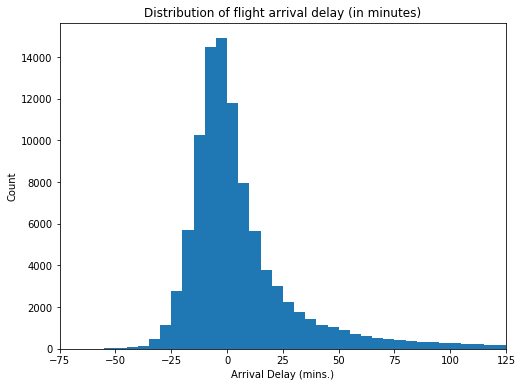

In [5]:
plt.figure(figsize=(8, 6))

bins = np.arange(df_flights.ArrDelay.min(),df_flights.ArrDelay.max(), 5)
plt.hist(data=df_flights, x='ArrDelay', bins=bins);
chart_metadata(xlim=(df_flights.ArrDelay.min(), 125),
               xlabel=('Arrival Delay (mins.)') ,
               ylabel=  ('Count'),
               title='Distribution of flight arrival delay (in minutes)'
              )

## Distribution of Delay Sources

> There are 5 main sources for flight delays, each has a direct impact on arrival time. Of these sources, three particular sources have shown considerable distribution ('Late Aircraft, 'NAS , Carrier). Using log transformation shows that the  distribution of all 3 sources are peaked at around 15 minutes.  

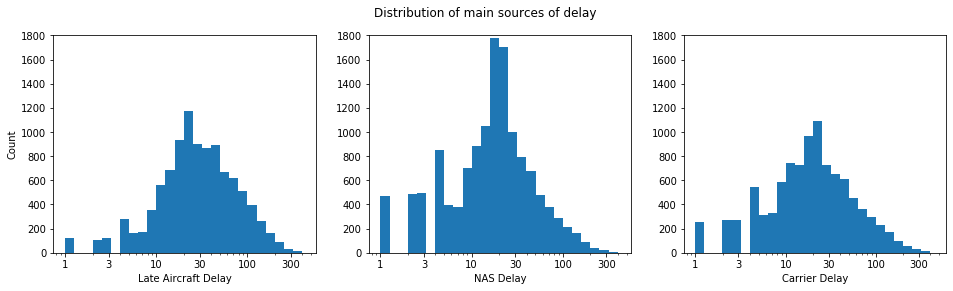

In [6]:
fig, ax = plt.subplots(ncols=3, figsize = [16,4])

delay_types = ['LateAircraftDelay', 'NASDelay',  'CarrierDelay', 'WeatherDelay', 'SecurityDelay', 'DepDelay', 'ArrDelay' ]
delay_labels = ['Late Aircraft Delay', 'NAS Delay', 'Carrier Delay',  'Weather Delay', 'Security Delay','DepDelay', 'ArrDelay']


for i, j in zip(delay_types[:3], range(len(delay_types)-4)):

    bins = 10 ** np.arange(0, np.log10(df_flights[i].max()+0.1), 0.1)
    ax[j].hist(df_flights[i], bins=bins)
    ax[j].set_xscale('log')
    tick_locs = [1, 3, 10, 30, 100, 300, 1000]
    ax[j].set_xticks(tick_locs)
    ax[j].set_xticklabels(tick_locs)
    ax[j].set_xlim(0, df_flights[i].max()+100)
    ax[j].set_ylim(0,1800)
    ax[j].set_xlabel("{}".format(delay_labels[j]))
ax[0].set_ylabel("Count")

plt.suptitle('Distribution of main sources of delay');


## Departure v.s. Arrival Delays 
It's pretty clear that most flights that departs late also arrives late. The relation between the two variables is very strong and most points are below 50 minutes . However not all the data is on a straight line (especially small delays) which may suggest that there some other variables influencing this Arrival delay.


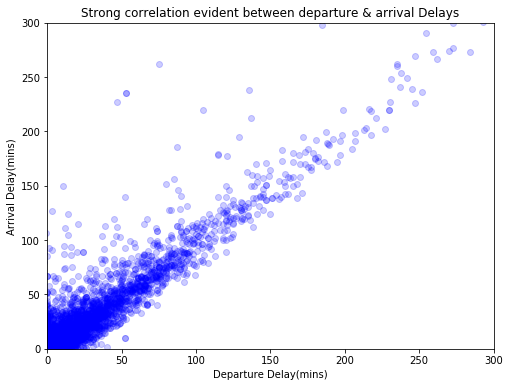

In [7]:
plt.figure(figsize=(8, 6))

df_delayed_sample = df_flights[df_flights.ArrDelay>0].sample(frac=0.1, replace=True, random_state=1) 
sb.regplot(data=df_delayed_sample, x='DepDelay', y='ArrDelay', fit_reg=False,
           x_jitter = 0.1, y_jitter = 0.1, scatter_kws = {'alpha' : 0.2}, line_kws={"color": "black"}, color='b')
#
chart_metadata(xlim=(0,300), ylim=(0,300), xlabel='Departure Delay(mins)',
       ylabel='Arrival Delay(mins)', title='Strong correlation evident between departure & arrival Delays')

## Delay Sources vs Arrival Performance

>Charts illustrates where most of the data lies and whether the variables are correlated. The heatmap shows a positive, relatively strong, correlation exist between all three delays (Late Aircraft, NAS, Carrier) and Arrival delay.  
Using heatmaps shows exactly what we were searching for. Exploring the small variables shows that each delay source has a lot of data points with small latency which are correlated with arrival delay. However, just like in previous slide, there are many points that aren't essentially explained by each chart.


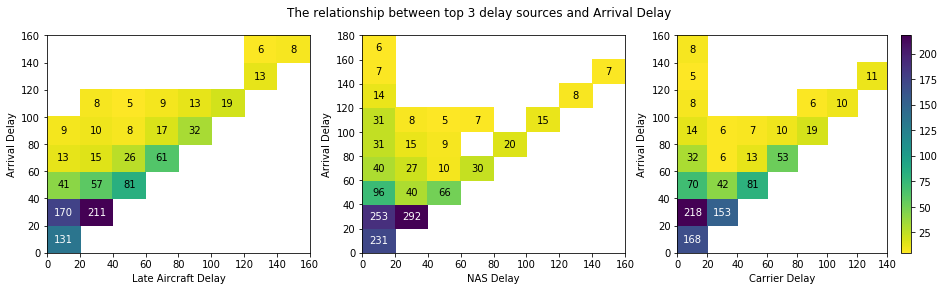

In [8]:

plt.figure(figsize=(16, 4))


bins_x = np.arange(0, 160+20, 20)
bins_y = np.arange(0, 180+20, 20)

x_limits = [(0, 160), (0, 160), (0, 140)]
y_limits = [(0, 160), (0, 180), (0, 160)]

for i, j in zip(delay_types[:3], range(len(delay_types)-4)):
    plt.subplot(1, 3, j+1)
    h2d = plt.hist2d(data=df_delayed_sample[df_delayed_sample[i]>0],
                 x=i, y='ArrDelay',
           bins=[bins_x, bins_y], cmin=5, cmap='viridis_r'); # I've set cmin to 5 to remove bins with very small counts
    heat_annotations(h2d[0], 10, 100)
    chart_metadata(xlabel=delay_labels[j], ylabel='Arrival Delay', xlim=x_limits[j], ylim=y_limits[j])

plt.colorbar();

plt.suptitle('The relationship between top 3 delay sources and Arrival Delay');

## Adding it all together
>Finding many data point not explained by the previous visuals led me to think, are these delay sources mutually exclusive or not? i.e. can one delay happen with another simultaneously?  
So adding up all three delays showed a very interesting relationship with Arrival delay. The correlation between **combined delay** variables and arrival delay proved to be **incredibly strong** where there is only negligible number of points that aren't explained by this relationship



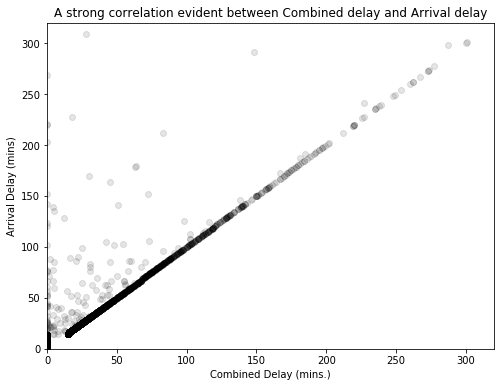

In [9]:
plt.figure(figsize=(8, 6))

df_delayed_sample['CombinedDelay'] = df_delayed_sample.CarrierDelay + \
                                     df_delayed_sample.NASDelay + \
                                     df_delayed_sample.LateAircraftDelay

#####
sb.regplot(data=df_delayed_sample, x='CombinedDelay', y='ArrDelay', x_jitter=0.1,
            fit_reg=False, 
           scatter_kws={"color": "black", 'alpha' : 0.1}, line_kws={"color": "violet"})
chart_metadata(xlabel='Combined Delay (mins.)',
               ylabel='Arrival Delay (mins)',
               xlim=(0, 320), ylim=(0,320),
               title='A strong correlation evident between Combined delay and Arrival delay')


## Delay Performance over Years 
> Exploring how flight performance (departure/arrival delay) changed over years looked very interesting. Not only the  variables continued to move together, both had a consistent increase in average number of delay minutes over years. Also, the average arrival delay seems to be always less than average departure delay. Answering this may require more data but I wonder whether there are measures taken to decrease Arrival time once a flight departed late?!



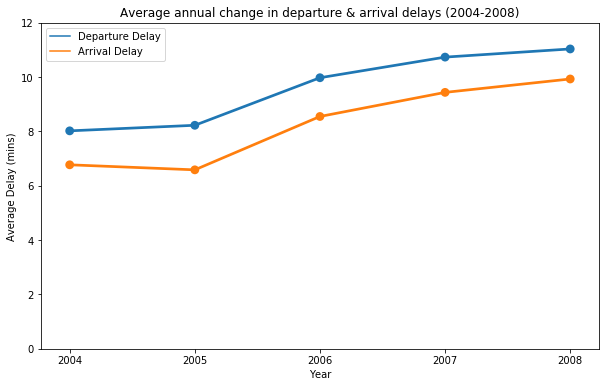

In [10]:
fig, ax = plt.subplots(figsize = [10, 6])

correlated_delays = ['DepDelay', 'ArrDelay']
colors = ['g','b']
correlated_labels = ['Departure Delay', 'Arrival Delay']


for d, j in zip(correlated_delays, range(len(correlated_delays))):
    sb.pointplot(data=df_flights, x='Year', y=d , errwidth=0, color=sb.color_palette()[j])
    ax.plot(np.NaN, np.NaN, '-', color=sb.color_palette()[j], label=correlated_labels[j])

plt.ylabel('Average Delay (mins)')
plt.ylim(0,12)
plt.title('Average annual change in departure & arrival delays (2004-2008)')
plt.legend();

## Final word... Delay Drivers over Years
>The general trend in the previous slide can be partially explained here. It's evident that some sources of delay, especially the top 3, have increased significantly (on average) over 5 years. The biggest average increase was Late Aircraft delay which increased by around 50% in 5 years which is very significant. This increase in itself can have its own underlying sources which is out of the scope of this project.  
Also consistent with previous findings, other sources of delay (Weather and security) remained flat over the last years.


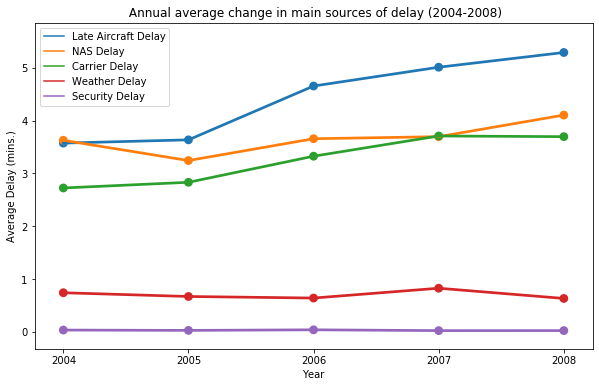

In [11]:
fig, ax = plt.subplots(figsize = [10,6])

    
for i, j in zip(delay_types[:5], range(len(delay_types)-2)):
    sb.pointplot(data=df_flights, x='Year', y=i, estimator=np.mean, errwidth=0, color=sb.color_palette()[j])
    ax.plot(np.NaN, np.NaN, '-', color=sb.color_palette()[j], label=delay_labels[j])

    
plt.ylabel('Average Delay (mins.)')
plt.title(' Annual average change in main sources of delay (2004-2008)')
plt.legend();